# Design and shape optimization of a metalens-assisted waveguide taper

Waveguide tapers are essential components for transitioning between waveguides of varying widths. However, achieving low-loss performance typically requires long taper lengths, which can pose challenges for the design of compact photonic circuits. To address this, various techniques have been developed to create compact, low-loss waveguide tapers, some of which were introduced in the previous [example](https://www.flexcompute.com/tidy3d/examples/notebooks/WaveguideSizeConverter/). In this notebook, we will explore the concept of designing an integrated metalens to facilitate mode conversion, enabling ultra-compact and low-loss tapers. The metalens is composed of slots of various lengths. This design approach is inspired by the work `Wang, Z., Li, T., Soman, A. et al. On-chip wavefront shaping with dielectric metasurface. Nat Commun 10, 3547 (2019)` [DOI: 10.1038/s41467-019-11578-y](https://doi.org/10.1038/s41467-019-11578-y).

<img src="img/on_chip_metalens.png" width=450 alt="Schematic of the metalens waveguide taper">

The notebook is structured as follows: In the first section, we explore how the slot length influences the phase shift of the waveguide mode. By conducting a parameter sweep of the slot length, we establish a phase map that serves as the foundation for designing the metalens. This design follows a parabolic phase profile to achieve focusing, which is then used to facilitate mode size conversion from a wide to a narrow waveguide. Compared to a standard linear taper, the integration of the metalens shows a substantial performance improvement. To push the performance further, we refine the initial design using adjoint-based shape optimization. This optimization significantly enhances the performance, highlighting the effectiveness of advanced computational techniques in photonic component optimization.

For more examples in integrated photonics or inverse design optimization, visit our [example library](https://www.flexcompute.com/tidy3d/learning-center/example-library/).

In [1]:
import autograd.numpy as np
import autograd as ag
import optax
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web

## Unit Cell Simulation
### Basic Simulation Setup

In this section, our goal is to obtain the relationship between the slot length and the phase shift of the waveguide mode. First, we define the basic parameters that will be used throughout the notebook. 

The wavelength range of interest is 1500 nm to 1600 nm.

In [2]:
lda0 = 1.55  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.5, 1.6, 31)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # width of the source frequency range

We will directly use the silicon and oxide media from Tidy3D's [material library](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/material_library.html). More specifically, we use the data from the widely used `Handbook of Optical Constants of Solids` by Palik.

In [3]:
si = td.material_library["cSi"]["Palik_Lossless"]

sio2 = td.material_library["SiO2"]["Palik_Lossless"]

In this model, we are working with 250 nm silicon with bottom oxide and top oxide cladding. The unit cell of the metalens has a periodicity of 500 nm. The width of the slot is fixed at 140 nm. We will investigate the slot length from 200 nm to 2.7 μm.

In [4]:
a = 0.5  # periodicity
w_slot = 0.14  # width of the slot
t_si = 0.25  # thickness of the silicon layer
l_slot_max = 2.7  # maximum slot length
l_slot_min = 0.2  # minimal slot length
buffer = 1  # buffer spacing
inf_eff = 1e3  # effective infinity

### Parameter Sweeping the Slot Length
Next we are going to perform a simple parameter sweep on the slot length and obtain the complex transmission coefficient. 

To do so, we define a function `make_unit_cell_sim` that takes the slot length as input and returns a [Simulation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html) object. A [ModeSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeSource.html) is used to launch the fundamental mode into the slab waveguide and a [ModeMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeMonitor.html) is used to measure transmission. Local periodic approximation is used so we apply periodic boundary condition in the $y$ direction.

In [5]:
# define the slab waveguide structure
slab = td.Structure(geometry=td.Box(center=(0, 0, 0), size=(td.inf, td.inf, t_si)), medium=si)

# add a mode source as excitation
mode_spec = td.ModeSpec(num_modes=1, target_neff=3.5)
mode_source = td.ModeSource(
    center=(-buffer, 0, 0),
    size=(0, td.inf, td.inf),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
)

# add a mode monitor to measure transmission at the output waveguide
mode_monitor = td.ModeMonitor(
    center=(l_slot_max + buffer, 0, 0),
    size=mode_source.size,
    freqs=[freq0],
    mode_spec=mode_spec,
    name="mode",
)

run_time = 3e-12  # simulation run time

# define simulation domain size
Lx = l_slot_max + 4 * buffer
Ly = a
Lz = 10 * t_si
sim_size = (Lx, Ly, Lz)


def make_unit_cell_sim(l_slot):

    # define the slot structure
    slot = td.Structure(
        geometry=td.Box(center=(l_slot / 2, 0, 0), size=(l_slot, w_slot, t_si)), medium=sio2
    )

    # construct simulation
    sim = td.Simulation(
        center=(l_slot_max / 2, 0, 0),
        size=sim_size,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=15, wavelength=lda0),
        structures=[slab, slot],
        sources=[mode_source],
        monitors=[mode_monitor],
        run_time=run_time,
        boundary_spec=td.BoundarySpec(
            x=td.Boundary.pml(), y=td.Boundary.periodic(), z=td.Boundary.pml()
        ),
        symmetry=(0, -1, 1),
        medium=sio2,
    )

    return sim

As a test, we create a simulation of arbitrary slot length and visualize it in 3D.

In [6]:
sim_test = make_unit_cell_sim(1)
sim_test.plot_3d()

Define a batch of simulations and submit the batch to the server.

In [7]:
l_slot_list = np.linspace(l_slot_min, l_slot_max, 11)

sims = {f"l_slot={l_slot:.2f}": make_unit_cell_sim(l_slot) for l_slot in l_slot_list}
batch = web.Batch(simulations=sims, verbose=True)
batch_results = batch.run(path_dir="data")

Output()

18:54:49 Eastern Daylight Time Started working on Batch containing 11 tasks.

18:55:02 Eastern Daylight Time Maximum FlexCredit cost: 0.275 for the whole     
                               batch.

                               Use 'Batch.real_cost()' to get the billed        
                               FlexCredit cost after the Batch has completed.

Output()

18:55:07 Eastern Daylight Time Batch complete.

Output()

After the simulations are complete, we can extract the transmission power and phase shift. 

In [8]:
T = np.zeros(len(l_slot_list))
phase = np.zeros(len(l_slot_list))

# extract the transmission power and phase shift
for i, l_slot in enumerate(l_slot_list):
    amp = batch_results[f"l_slot={l_slot:.2f}"]["mode"].amps.sel(direction="+").values[0][0]
    T[i] = np.abs(amp) ** 2
    phase[i] = np.angle(amp)

Plot the results. We can see that the transmission stays above 90% across the slot length and the phase shift spans over a 2$\pi$ range, which is necessary to design a metalens in the next step.

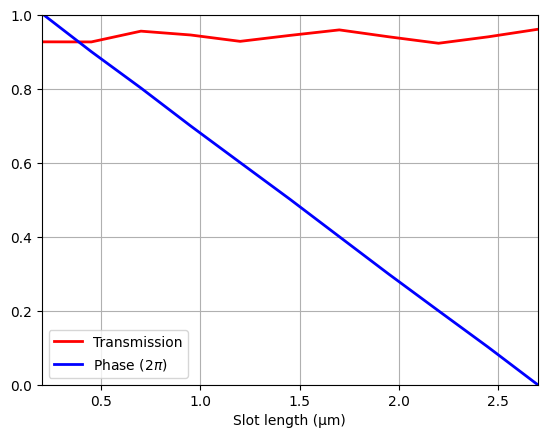

In [9]:
unwrapped_phase = np.unwrap(phase - phase[-1]) / (2 * np.pi) + 1
plt.plot(l_slot_list, T, c="red", linewidth=2, label="Transmission")
plt.plot(l_slot_list, unwrapped_phase, c="blue", linewidth=2, label=f"Phase (2$\pi$)")
plt.xlabel("Slot length (μm)")
plt.xlim(l_slot_min, l_slot_max)
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.show()

## On-chip Metalens Design
### Determine the Slot Lengths to Achieve Focusing
To design a focusing metalens, the phase shift of the transmitted wave is defined by $\phi(y) = \frac{2\pi}{\lambda_0} n_{eff}(f-\sqrt{f^2+y^2})$, where $y$ is the lateral position of the slot, $\lambda_0$ is the free space wavelength, $n_{eff}$ is the effective refractive index of the slab waveguide, and $f$ is the focal length. With this equation and the previously obtained relation between the slot length and phase shift, we can perform an interpolation to determine the desired slot lengths for the metalens.

Our goal is to design a metalens-assisted waveguide taper that transitions between an 11 μm wide waveguide to a single-mode 500 nm narrow waveguide. More specifically, we will fix the focal length to 10 μm, which makes the taper very compact.

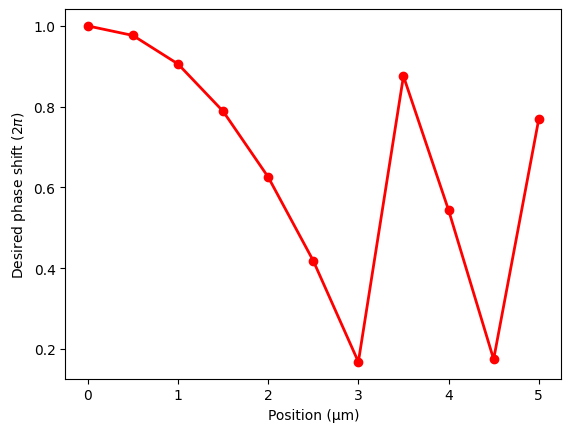

In [10]:
# function that determines the desired slot length given the desired phase shift by interpolation
def find_slot_length(desired_phase):
    desired_l_slot = np.interp(desired_phase, unwrapped_phase[::-1], l_slot_list[::-1])
    return desired_l_slot


w_waveguide_wide = 11  # width of the wide waveguide
w_waveguide_narrow = 0.5  # width of the narrow waveguide
n_eff = 2.93  # effective index of the slab waveguide
f = 10  # focal length

# y positions of the slots
ys = np.arange(w_waveguide_wide / 2 - a, -a, -a)

# desired phase distribution
desired_phases = 1 - np.mod((1 / lda0) * n_eff * (np.sqrt(f**2 + ys**2) - f), 1)

plt.scatter(ys, desired_phases, c="red")
plt.plot(ys, desired_phases, c="red", linewidth=2)
plt.xlabel("Position (μm)")
plt.ylabel("Desired phase shift (2$\pi$)")
plt.show()

# desired slot lengths
desired_l_slots = np.array(
    [np.interp(desired_phases[i], unwrapped_phase[::-1], l_slot_list[::-1]) for i in range(len(ys))]
)

### Simulate the Metalens-assisted taper

To simulate the metalens-assisted taper, we can just define one simulation. However, to facilitate later optimization, we will define a function  `make_sim`, whose input argument is an array, where each element represents the slot length in one unit cell. 

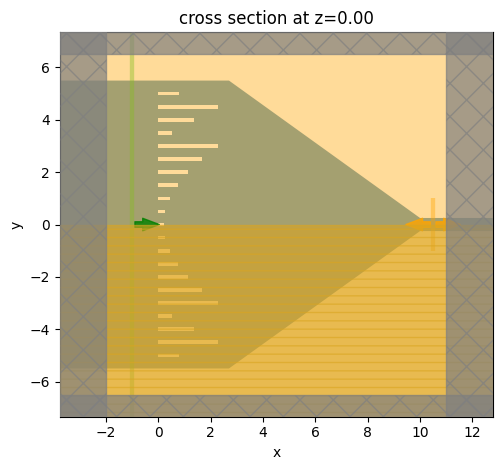

In [11]:
# define the vertices of the taper
vertices = [
    (-inf_eff, w_waveguide_wide / 2),
    (l_slot_max, w_waveguide_wide / 2),
    (f, w_waveguide_narrow / 2),
    (inf_eff, w_waveguide_narrow / 2),
    (inf_eff, -w_waveguide_narrow / 2),
    (f, -w_waveguide_narrow / 2),
    (l_slot_max, -w_waveguide_wide / 2),
    (-inf_eff, -w_waveguide_wide / 2),
]

# define the taper structure
taper = td.Structure(
    geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(-t_si / 2, t_si / 2)), medium=si
)

# add a field monitor to visualize the field in the xy plane
field_monitor_xy = td.FieldMonitor(
    center=(0, 0, 0), size=(td.inf, td.inf, 0), freqs=[freq0], name="field_xy"
)

# add a mode monitor to measure transmission at the output waveguide
mode_monitor = td.ModeMonitor(
    center=(f + buffer / 2, 0, 0),
    size=(0, 4 * w_waveguide_narrow, 10 * t_si),
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode",
)

# function to create a simulation given the slot lengths
def make_sim(l_slots):

    # create the slot geometries
    slots_geo = []
    for (y, l_slots) in zip(ys, l_slots):
        slots_geo.append(
            td.Box(center=(l_slots / 2, y, 0), size=(l_slots, w_slot, t_si))
        )

        if y!=0:
            slots_geo.append(
                td.Box(center=(l_slots / 2, -y, 0), size=(l_slots, w_slot, t_si))
            )

    # create the slot structures
    slots = [td.Structure(geometry=s, medium=sio2) for s in slots_geo]

    # simulation domain box
    sim_box = td.Box.from_bounds(
        rmin=(-2 * buffer, -w_waveguide_wide / 2 - buffer, -5 * t_si),
        rmax=(f + buffer, w_waveguide_wide / 2 + buffer, 5 * t_si),
    )
    # define simulation
    sim = td.Simulation(
        center=sim_box.center,
        size=sim_box.size,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=15, wavelength=lda0),
        structures=[taper] + slots,
        sources=sim_test.sources,
        monitors=[field_monitor_xy, mode_monitor],
        run_time=run_time,
        boundary_spec=td.BoundarySpec(
            x=td.Boundary.absorber(
                num_layers=60
            ),  # use absorber boundary to avoid simulation divergence
            y=td.Boundary.pml(),
            z=td.Boundary.pml(),
        ),
        symmetry=(0, -1, 1),
        medium=sio2,
    )

    return sim


# create the initial design and visualize it
sim_meta = make_sim(desired_l_slots)
sim_meta.plot(z=0)
plt.show()

Before submitting the simulation, we can estimate the cost of the simulation.

In [12]:
job = web.Job(simulation=sim_meta, task_name="metalens taper", verbose=True)
estimated_cost = web.estimate_cost(job.task_id)

18:55:15 Eastern Daylight Time Created task 'metalens taper' with task_id       
                               'fdve-adf3c784-e28b-4931-a252-ef7af8d98682' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=91330;https://tidy3d.simulation.cloud/workbench?taskId=fdve-adf3c784-e28b-4931-a252-ef7af8d98682\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=496227;https://tidy3d.simulation.cloud/workbench?taskId=fdve-adf3c784-e28b-4931-a252-ef7af8d98682\taskId]8;;\
                               ]8;id=91330;https://tidy3d.simulation.cloud/workbench?taskId=fdve-adf3c784-e28b-4931-a252-ef7af8d98682\=]8;;\]8;id=454570;https://tidy3d.simulation.cloud/workbench?taskId=fdve-adf3c784-e28b-4931-a252-ef7af8d98682\fdve]8;;\]8;id=91330;https://tidy3d.simulation.cloud/workbench?taskId=fdve-adf3c784-e28b-4931-a252-ef7af8d98682\-adf3c784-e28b-4931-a252-ef7af8d98682']8;;\.

Output()

18:55:16 Eastern Daylight Time Maximum FlexCredit cost: 0.225. Minimum cost     
                               depends on task execution details. Use           
                               'web.real_cost(task_id)' to get the billed       
                               FlexCredit cost after a simulation run.

Run the simulation.

In [13]:
sim_data_meta = job.run(path="data/sim_meta.hdf5")

                               status = success

Output()

18:55:20 Eastern Daylight Time loading simulation from data/sim_meta.hdf5

### Simulate the Regular Linear Taper

As a comparison, we can also simulate the regular linear taper without the metalens. To do so, we only need to copy the previous simulation and update the `structures` to only include the taper.

In [14]:
sim_taper = sim_meta.copy(update={"structures": [taper]})
sim_data_taper = web.run(simulation=sim_taper, task_name="linear taper", path="data/sim_taper.hdf5")

                               Created task 'linear taper' with task_id         
                               'fdve-4f522d81-f877-42c6-aaf1-35ac96ac9186' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=483200;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f522d81-f877-42c6-aaf1-35ac96ac9186\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=276886;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f522d81-f877-42c6-aaf1-35ac96ac9186\taskId]8;;\
                               ]8;id=483200;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f522d81-f877-42c6-aaf1-35ac96ac9186\=]8;;\]8;id=705997;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f522d81-f877-42c6-aaf1-35ac96ac9186\fdve]8;;\]8;id=483200;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f522d81-f877-42c6-aaf1-35ac96ac9186\-4f522d81-f877-42c6-aaf1-35ac96ac9186']8;;\.

Output()

18:55:22 Eastern Daylight Time status = queued

                               To cancel the simulation, use                    
                               'web.abort(task_id)' or 'web.delete(task_id)' or 
                               abort/delete the task in the web UI. Terminating 
                               the Python script will not stop the job running  
                               on the cloud.

Output()

18:55:30 Eastern Daylight Time status = preprocess

18:55:32 Eastern Daylight Time Maximum FlexCredit cost: 0.186. Use              
                               'web.real_cost(task_id)' to get the billed       
                               FlexCredit cost after a simulation run.

                               starting up solver

                               running solver

Output()

18:55:59 Eastern Daylight Time early shutoff detected at 20%, exiting.

                               status = postprocess

Output()

18:56:01 Eastern Daylight Time status = success

18:56:02 Eastern Daylight Time View simulation result at                        
                               ]8;id=10327;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f522d81-f877-42c6-aaf1-35ac96ac9186\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=207934;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f522d81-f877-42c6-aaf1-35ac96ac9186\taskId]8;;\
                               ]8;id=10327;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f522d81-f877-42c6-aaf1-35ac96ac9186\=]8;;\]8;id=606089;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f522d81-f877-42c6-aaf1-35ac96ac9186\fdve]8;;\]8;id=10327;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f522d81-f877-42c6-aaf1-35ac96ac9186\-4f522d81-f877-42c6-aaf1-35ac96ac9186']8;;\.

Output()

18:56:03 Eastern Daylight Time loading simulation from data/sim_taper.hdf5

### Result Comparison

Now we can compare the metalens-assisted taper and the regular linear taper. First plot the field distribution to visualize the focusing in both cases. 

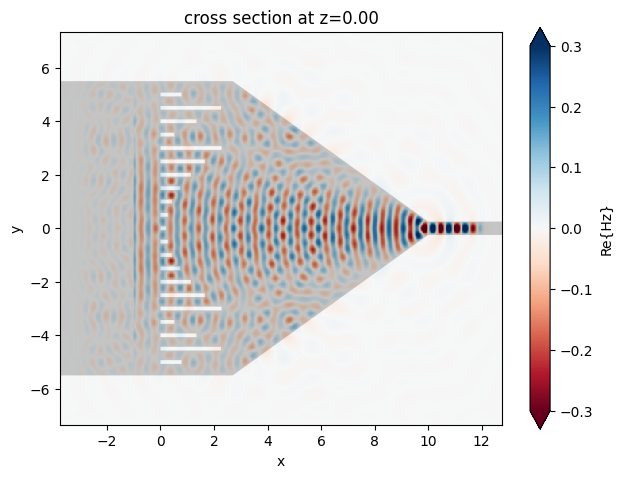

In [15]:
sim_data_meta.plot_field(
    field_monitor_name="field_xy", field_name="Hz", val="real", vmin=-0.3, vmax=0.3
)

plt.show()

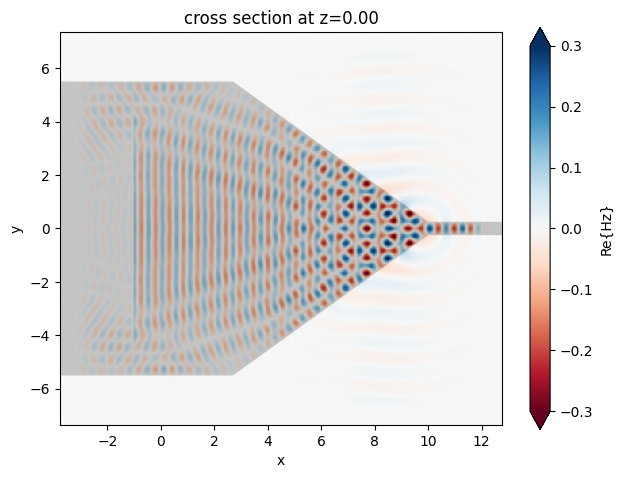

In [16]:
sim_data_taper.plot_field(
    field_monitor_name="field_xy", field_name="Hz", val="real", vmin=-0.3, vmax=0.3
)

plt.show()

Plot the insertion loss. Here we see a huge improvement from including the metalens in the waveguide. 

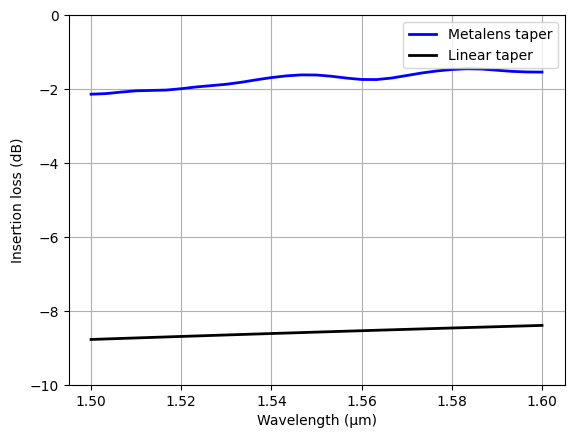

In [17]:
T_meta = np.abs(sim_data_meta["mode"].amps.sel(direction="+").values) ** 2
T_taper = np.abs(sim_data_taper["mode"].amps.sel(direction="+").values) ** 2
plt.plot(ldas, 10 * np.log10(T_meta), c="blue", linewidth=2, label="Metalens taper")
plt.plot(ldas, 10 * np.log10(T_taper), c="black", linewidth=2, label="Linear taper")
plt.ylim(-10, 0)
plt.xlabel("Wavelength (μm)")
plt.ylabel("Insertion loss (dB)")
plt.legend()
plt.grid()
plt.show()

## Shape Optimization of the Metalens

Even though the metalens-assisted taper outperforms the regular taper significantly, the current design is likely not optimal. To optimize the design, we apply adjoint-based shape optimization, which is very easy to do in `Tidy3D`. The objective function is simply defined as the average of the transmission over the entire wavelength range.

In [18]:
def J(l_slots):
    sim = make_sim(l_slots)
    sim_data = web.run(simulation=sim, task_name="invdes", verbose=False, local_gradient=False)

    return np.sum(np.abs(sim_data["mode"].amps.sel(mode_index=0, direction="+").values) ** 2) / len(
        ldas
    )

Test if the gradient tracking is working properly.

In [19]:
dJ = ag.value_and_grad(J)
val, grad = dJ(desired_l_slots)
print(val)
print(grad)

0.6702124385811784
[-0.00439427  0.02416531  0.06663957 -0.00663492 -0.01646496  0.15406826
  0.00337459 -0.00108695 -0.14306788 -0.11359426 -0.03154911]


We will run the optimization for 30 iterations using the `adam` optimizer. We will set the maximum and minimal slot lengths to 3 μm and 100 nm, respectively. We use a wider range compared to the previously used slot length range for the unit cell design to enlarge the design parameter space. These values can be tuned according to the specific fabrication constraint.

In [20]:
# hyperparameters
num_steps = 30
learning_rate = 0.02

l_slot_max = 3  # maximum slot length
l_slot_min = 0.1  # minimal slot length

# initialize adam optimizer with starting parameters
params = np.array(desired_l_slots)
optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(params)

# store history
J_history = []
params_history = [params]

for i in range(num_steps):
    # compute gradient and current objective function value
    value, gradient = dJ(params)

    # outputs
    print(f"step = {i + 1}")
    print(f"\tJ = {value:.2e}")
    print(f"\tgrad_norm = {np.linalg.norm(gradient):.2e}")

    # compute and apply updates to the optimizer based on gradient (-1 sign to maximize obj_fn)
    updates, opt_state = optimizer.update(-gradient, opt_state, params)
    params = optax.apply_updates(params, updates)
    params = np.array(params)
    params = np.clip(params, l_slot_min, l_slot_max)

    # save history
    J_history.append(value)
    params_history.append(params)

step = 1
	J = 6.70e-01
	grad_norm = 2.52e-01
step = 2
	J = 6.82e-01
	grad_norm = 2.23e-01
step = 3
	J = 6.93e-01
	grad_norm = 1.91e-01
step = 4
	J = 7.03e-01
	grad_norm = 1.68e-01
step = 5
	J = 7.12e-01
	grad_norm = 1.51e-01
step = 6
	J = 7.19e-01
	grad_norm = 1.32e-01
step = 7
	J = 7.27e-01
	grad_norm = 1.13e-01
step = 8
	J = 7.32e-01
	grad_norm = 9.63e-02
step = 9
	J = 7.36e-01
	grad_norm = 9.94e-02
step = 10
	J = 7.39e-01
	grad_norm = 1.05e-01
step = 11
	J = 7.40e-01
	grad_norm = 1.16e-01
step = 12
	J = 7.40e-01
	grad_norm = 1.24e-01
step = 13
	J = 7.41e-01
	grad_norm = 1.29e-01
step = 14
	J = 7.42e-01
	grad_norm = 1.31e-01
step = 15
	J = 7.43e-01
	grad_norm = 1.30e-01
step = 16
	J = 7.44e-01
	grad_norm = 1.27e-01
step = 17
	J = 7.45e-01
	grad_norm = 1.21e-01
step = 18
	J = 7.47e-01
	grad_norm = 1.07e-01
step = 19
	J = 7.49e-01
	grad_norm = 1.01e-01
step = 20
	J = 7.51e-01
	grad_norm = 8.81e-02
step = 21
	J = 7.52e-01
	grad_norm = 8.55e-02
step = 22
	J = 7.54e-01
	grad_norm = 7.46e-

Plot the objective function history. The average transmission power easily improved for about 10% during the optimization.

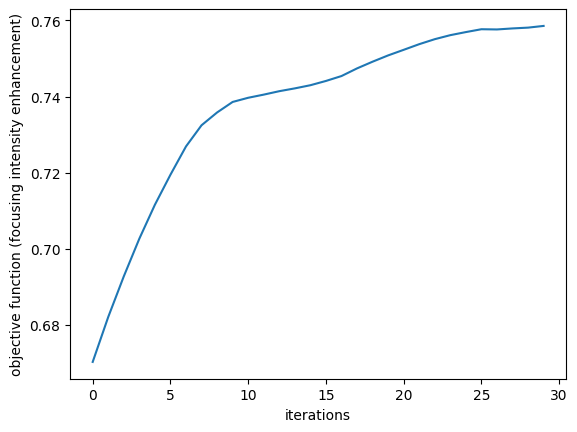

In [21]:
plt.plot(J_history)
plt.xlabel("iterations")
plt.ylabel("objective function (focusing intensity enhancement)")
plt.show()

Get the optimized design.

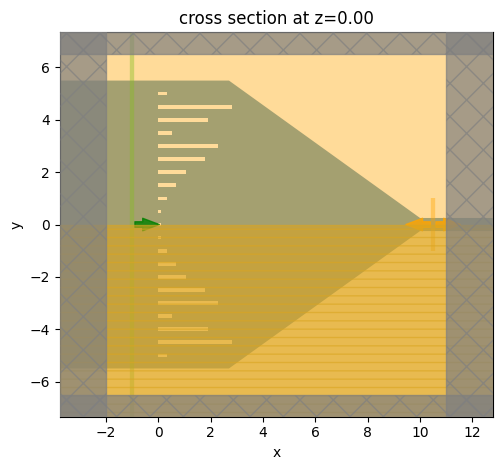

In [22]:
l_slots_opt = params_history[-1]
sim_opt = make_sim(l_slots_opt)
sim_opt.plot(z=0)
plt.show()

Run the optimized design again and plot the results.

In [23]:
sim_data_opt = web.run(simulation=sim_opt, task_name="optimized")

19:44:58 Eastern Daylight Time Created task 'optimized' with task_id            
                               'fdve-df07cc6e-caa0-43d9-ad64-f145100e1f0e' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=480860;https://tidy3d.simulation.cloud/workbench?taskId=fdve-df07cc6e-caa0-43d9-ad64-f145100e1f0e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=961295;https://tidy3d.simulation.cloud/workbench?taskId=fdve-df07cc6e-caa0-43d9-ad64-f145100e1f0e\taskId]8;;\
                               ]8;id=480860;https://tidy3d.simulation.cloud/workbench?taskId=fdve-df07cc6e-caa0-43d9-ad64-f145100e1f0e\=]8;;\]8;id=316281;https://tidy3d.simulation.cloud/workbench?taskId=fdve-df07cc6e-caa0-43d9-ad64-f145100e1f0e\fdve]8;;\]8;id=480860;https://tidy3d.simulation.cloud/workbench?taskId=fdve-df07cc6e-caa0-43d9-ad64-f145100e1f0e\-df07cc6e-caa0-43d9-ad64-f145100e1f0e']8;;\.

Output()

19:45:00 Eastern Daylight Time status = queued

                               To cancel the simulation, use                    
                               'web.abort(task_id)' or 'web.delete(task_id)' or 
                               abort/delete the task in the web UI. Terminating 
                               the Python script will not stop the job running  
                               on the cloud.

Output()

19:45:04 Eastern Daylight Time status = preprocess

19:45:07 Eastern Daylight Time Maximum FlexCredit cost: 0.224. Use              
                               'web.real_cost(task_id)' to get the billed       
                               FlexCredit cost after a simulation run.

                               starting up solver

                               running solver

Output()

19:45:19 Eastern Daylight Time early shutoff detected at 32%, exiting.

                               status = postprocess

Output()

19:45:20 Eastern Daylight Time status = success

                               View simulation result at                        
                               ]8;id=780431;https://tidy3d.simulation.cloud/workbench?taskId=fdve-df07cc6e-caa0-43d9-ad64-f145100e1f0e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=842649;https://tidy3d.simulation.cloud/workbench?taskId=fdve-df07cc6e-caa0-43d9-ad64-f145100e1f0e\taskId]8;;\
                               ]8;id=780431;https://tidy3d.simulation.cloud/workbench?taskId=fdve-df07cc6e-caa0-43d9-ad64-f145100e1f0e\=]8;;\]8;id=376190;https://tidy3d.simulation.cloud/workbench?taskId=fdve-df07cc6e-caa0-43d9-ad64-f145100e1f0e\fdve]8;;\]8;id=780431;https://tidy3d.simulation.cloud/workbench?taskId=fdve-df07cc6e-caa0-43d9-ad64-f145100e1f0e\-df07cc6e-caa0-43d9-ad64-f145100e1f0e']8;;\.

Output()

19:45:22 Eastern Daylight Time loading simulation from simulation_data.hdf5

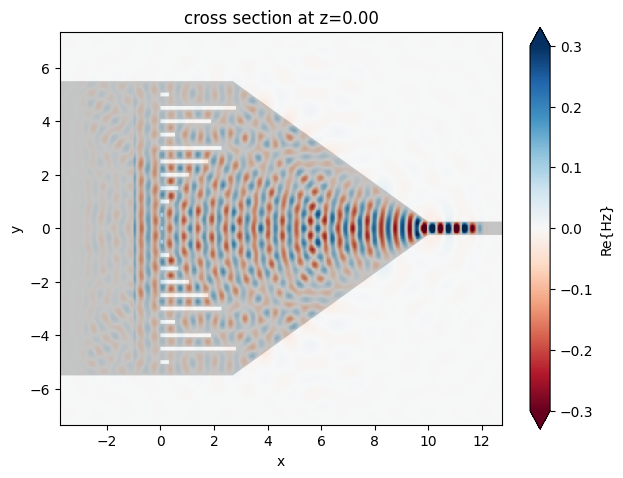

In [24]:
sim_data_opt.plot_field(
    field_monitor_name="field_xy", field_name="Hz", val="real", vmin=-0.3, vmax=0.3
)

plt.show()

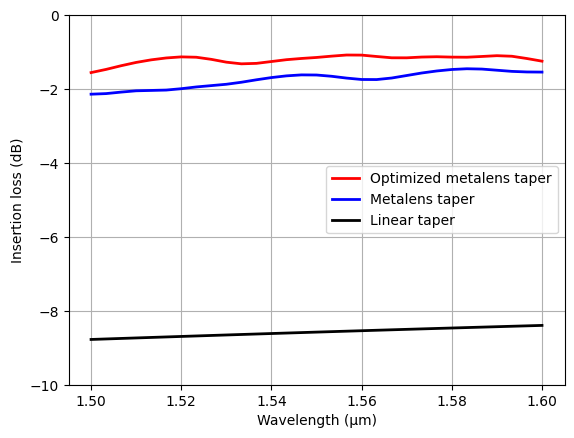

In [25]:
T_opt = np.abs(sim_data_opt["mode"].amps.sel(direction="+").values) ** 2
plt.plot(ldas, 10 * np.log10(T_opt), c="red", linewidth=2, label="Optimized metalens taper")
plt.plot(ldas, 10 * np.log10(T_meta), c="blue", linewidth=2, label="Metalens taper")
plt.plot(ldas, 10 * np.log10(T_taper), c="black", linewidth=2, label="Linear taper")
plt.xlabel("Wavelength (μm)")
plt.ylabel("Insertion loss (dB)")
plt.ylim(-10, 0)
plt.legend()
plt.grid()
plt.show()

Lastly, we can visualize how much each slot length has changed between the initial design and the optimized design.

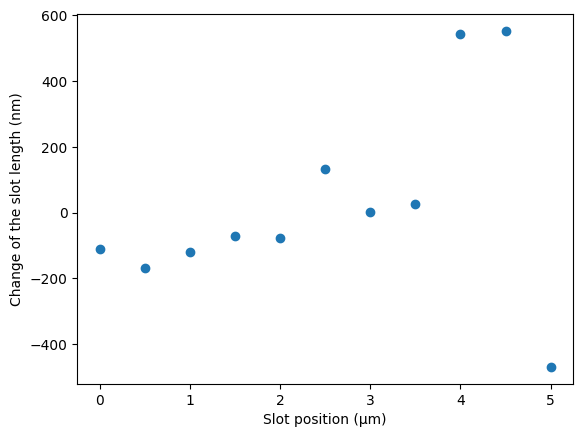

In [26]:
delta_l_slot = l_slots_opt - desired_l_slots

plt.scatter(ys, 1e3 * delta_l_slot)
plt.xlabel("Slot position (μm)")
plt.ylabel("Change of the slot length (nm)")
plt.show()

## Final Remarks

In the optimization, we only optimize the slot lengths. In principle, other parameters such as the slot positions, widths, and taper shape can be optimized at the same time to potentially achieve a better result. Users are encouraged to explore these possibilities. 

In the follow-up work `Ma, Wei, Hou, Maojing, Luo, Ruiqi, Xiong, Bo, Liu, Nan, Liu, Guandong and Chu, Tao. "Topologically-optimized on-chip metamaterials for ultra-short-range light focusing and mode-size conversion" Nanophotonics, vol. 12, no. 6, 2023, pp. 1189-1197.` [DOI: 10.1515/nanoph-2023-0036](https://doi.org/10.1515/nanoph-2023-0036), the authors applied level-set-based shape optimization, which allows a larger parameter space compared to what's demonstrated in this notebook. Interested users are also encouraged to explore this direction by following our level set optimization [example](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin10YBranchLevelSet/).  